# Histopathologic Cancer Detection
Based on images taken from digital pathology scans, we will train a model in an attempt to accurately predict wether or not metastatic cancer, cancer that has spread from its original source, is present. The data consists of a train and test set of images, with labels. 

### Exploratory Data Analysis
We will first analyze and study the data using OpenCV along with the usual data visualization python libraries. I am choosing OpenCV because it is a powerful open source library with advanced features. 

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# let's first take a look at labels

img_labels = pd.read_csv('cancer-data/train_labels.csv')

img_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [3]:
samples = pd.read_csv('cancer-data/sample_submission.csv')

samples.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [4]:
print(img_labels.shape)
print(samples.shape)

(220025, 2)
(57458, 2)


In [5]:
# check for any necessary data cleaning needed

duplicates = img_labels[img_labels.duplicated()]
print(duplicates)

null_vals = img_labels.isnull()
null_count = null_vals.sum()
print(null_count)

Empty DataFrame
Columns: [id, label]
Index: []
id       0
label    0
dtype: int64


In [6]:
total_positive_cases = (img_labels['label'] ==1 ).sum()
print("Total positive metastatic cancer cases out of 220,025:", total_positive_cases)

Total positive metastatic cancer cases out of 220,025: 89117


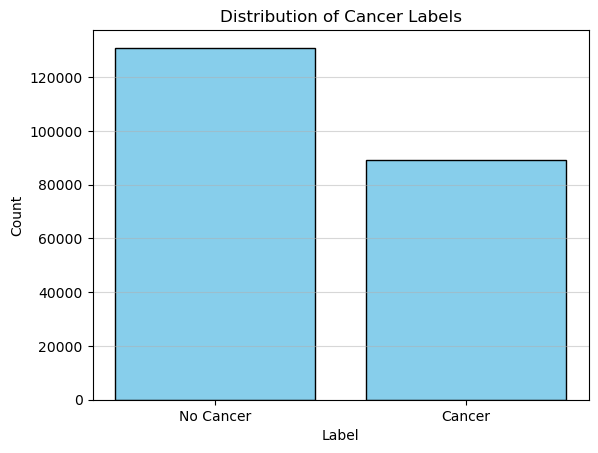

In [7]:
# plotting cases on histogram
plt.hist(img_labels['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='skyblue', edgecolor='black')

plt.title('Distribution of Cancer Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])

plt.grid(axis='y', alpha=0.5)
plt.show()

In [8]:
train = "cancer-data/train"
test = "cancer-data/test"
print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [9]:
# taking a look at some images
def display_random_images(image_dir, num_images=10, rows=2, cols=5):
    image_ids = os.listdir(image_dir)
    np.random.shuffle(image_ids)
    image_ids = image_ids[:num_images]
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    
    for i, filename in enumerate(image_ids):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        row = i // cols
        col = i % cols
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

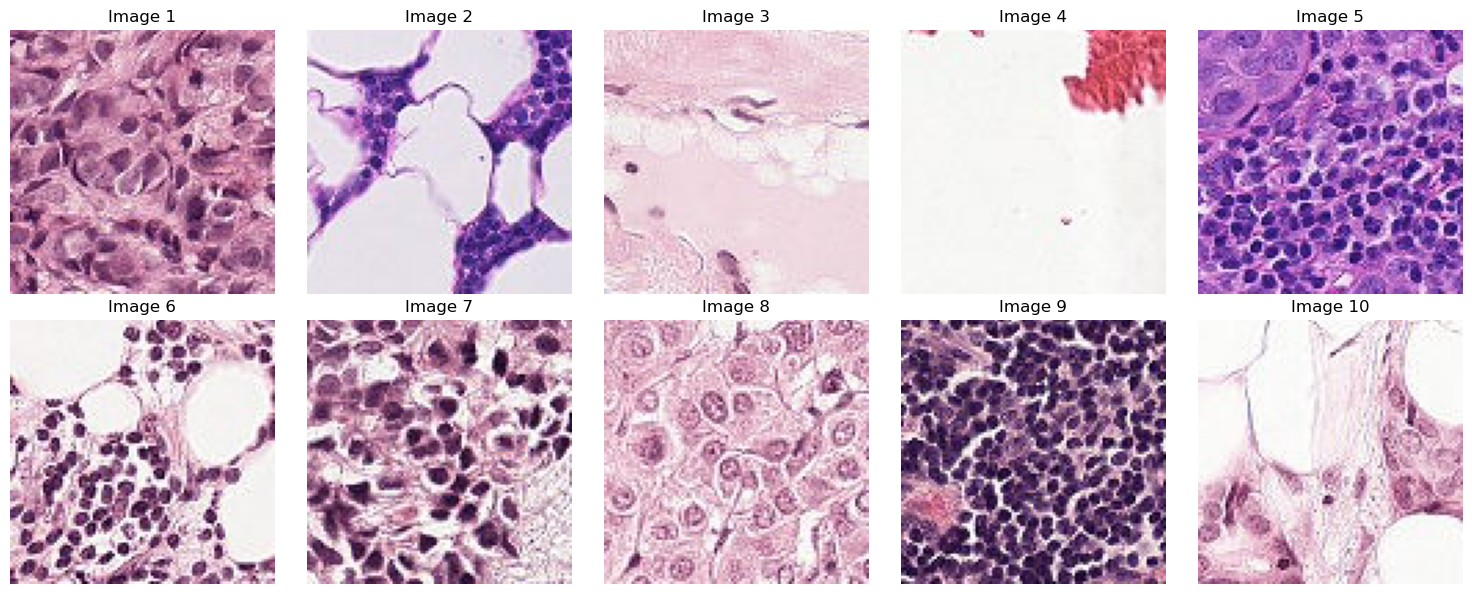

In [10]:
display_random_images(train)

In [11]:
# checking size of image

first_img = "cancer-data/train/0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif"

img = cv2.imread(first_img, cv2.IMREAD_UNCHANGED)

height, width = img.shape[:2]
print("Shape of the first image:")
print("Height:", height)
print("Width:", width)

Shape of the first image:
Height: 96
Width: 96


In [12]:
# now looking at images specifically of cancerous vs non-cancerous

cancer = img_labels.loc[img_labels['label']==1]['id'].values 
non_cancer = img_labels.loc[img_labels['label']==0]['id'].values 

In [13]:
def plot_fig(ids, title, train_dir, nrows=5, ncols=10):

    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    
    for i, j in enumerate(ids[:nrows * ncols]):
        fname = os.path.join(train_dir, j + '.tif')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        cv2.rectangle(img, (0, 0), (95, 95), (255, 255, 255), 1)
        
        ax[i // ncols, i % ncols].imshow(img)
        ax[i // ncols, i % ncols].axis('off')

    plt.suptitle(title, y=0.94)
    plt.show()

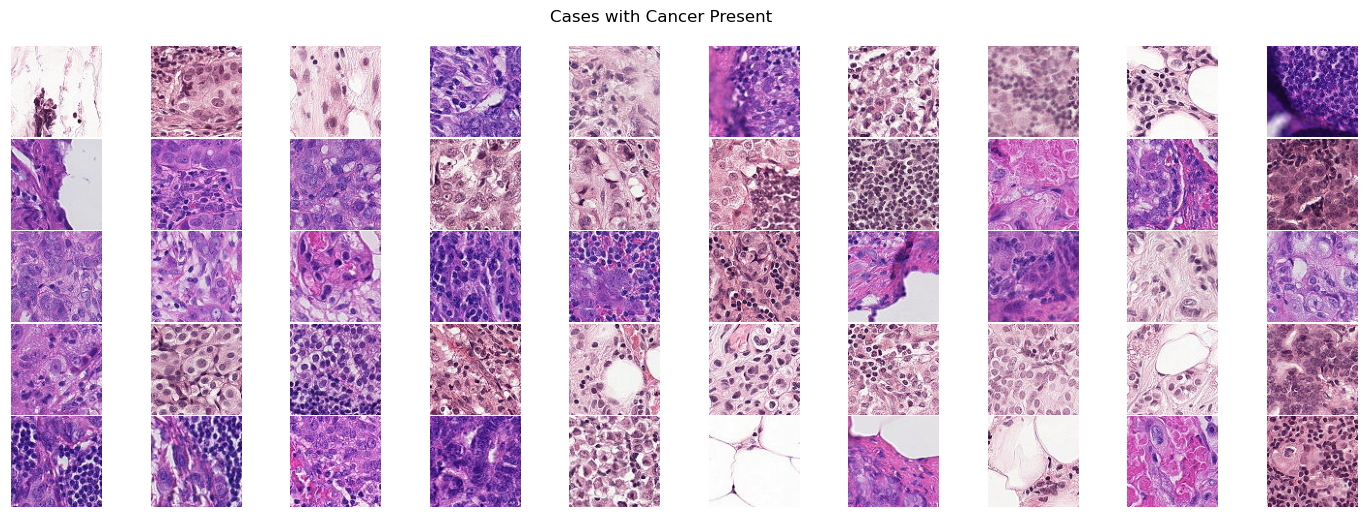

In [14]:
plot_fig(cancer, "Cases with Cancer Present", train)

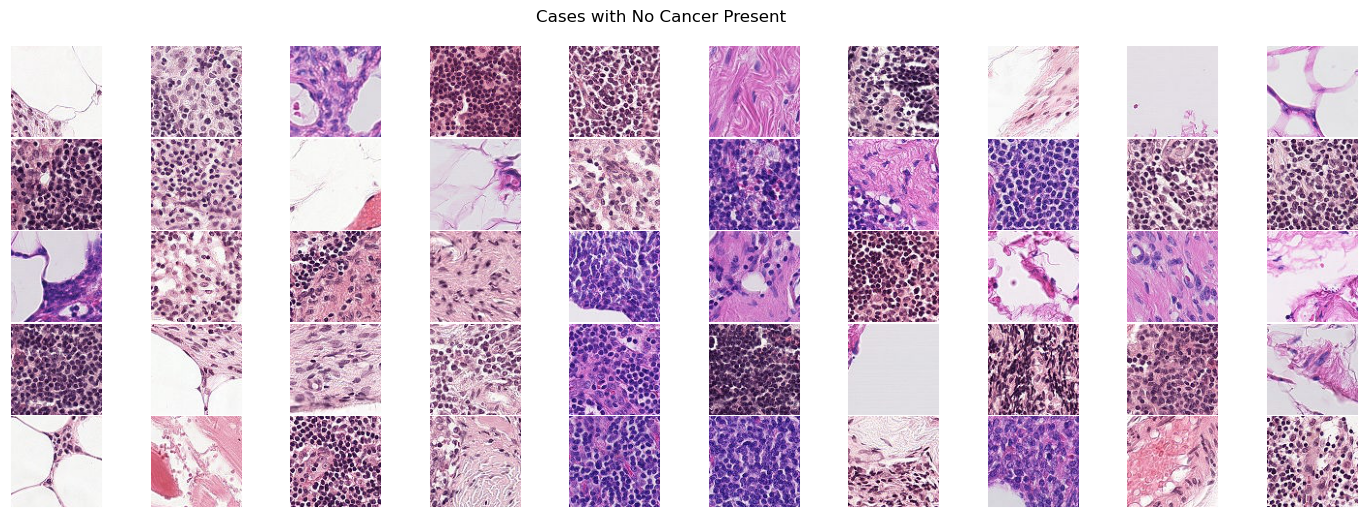

In [15]:
plot_fig(non_cancer, "Cases with No Cancer Present", train)

### EDA Findings
- Very large set of training data
- Images are 96x96x3
- Data has plenty of cancer cases to learn from
- About 40% of training set are positive for cancer instances

## Model Building
For this task, I will follow a variation of the VGG Net architecture for my model, with some changes. The output layer will be a sigmoid function since we are dealing with binary classification. 

In [16]:
# prepare training data and testing data

'''
I am going to restric the total amount of training data to 8000 examples. The 220k training examples is too large for my computer to handle. 
I will also randomize and implement a 60/40 split between non-cancerous and cancerous images in the training data - this will mirror the percentage split 
we saw in the histogram closely. 
'''

import shutil
import random

cancer = img_labels.loc[img_labels['label']==1]['id'].values 
cancer = img_labels.loc[img_labels['label'] == 1]['id'].values 
non_cancer = img_labels.loc[img_labels['label'] == 0]['id'].values 

total_images = 8000
non_cancer_count = int(0.6 * total_images)
cancer_count = total_images - non_cancer_count

non_cancer_df = pd.DataFrame({'id': non_cancer})
cancer_df = pd.DataFrame({'id': cancer})

non_cancer_sample = non_cancer_df.sample(n=non_cancer_count, random_state=42)
cancer_sample = cancer_df.sample(n=cancer_count, random_state=42)

selected_images = pd.concat([non_cancer_sample, cancer_sample])

# new dir for selected images
selected_images_dir = "selected_images"
os.makedirs(selected_images_dir, exist_ok=True)

for index, row in selected_images.iterrows():
    img_id = row['id']  # Corrected from row['label']
    src_path = os.path.join('cancer-data/train', f"{img_id}.tif")
    dst_path = os.path.join(selected_images_dir, f"{img_id}.tif")  # Removed appending label
    shutil.copy(src_path, dst_path)

print("Number of selected images:", len(os.listdir(selected_images_dir)))                 

Number of selected images: 8000


In [17]:
selected_images.head()

id
72416  941ffe73059292e0effd4e81ca9363c117afc2f4
22892  43b6acadb31161c9281460efa3fad0b992a92837
94073  64cfb56ddf41e2a871ac5164d61e50b238b9ed1b
92177  9464cf403653088420cdb78acacd8cf7fa2255e4
55930  346bc5b2d383d70dfccb8fe9102c7f55687f5f52

In [18]:
image_files = os.listdir(selected_images_dir)

image_ids = [filename.split('.')[0] for filename in image_files]
labels_dict = dict(zip(img_labels['id'], img_labels['label']))

# map images to labels
labels = [labels_dict[image_id] for image_id in image_ids]

In [36]:
# prep for test data

test_image_files = os.listdir(test)
random_test_images = random.sample(test_image_files, 2000)
print("Number of selected test images: {}".format(len(random_test_images)))

Number of selected test images: 2000


In [37]:
random_test_image_ids = [filename.split('.')[0] for filename in random_test_images]

test_labels_dict = dict(zip(samples['id'], samples['label']))

# map images to labels
random_test_labels = [test_labels_dict[image_id] for image_id in random_test_image_ids]

In [38]:
test_data = pd.DataFrame({
    'filename': random_test_images,
    'label': random_test_labels
})

test_data.head()

filename  label
0  3d2a43345262803757e2bb6503b440d9953638f8.tif      0
1  d7fc7615962b457c151eb35cd8d792b16c1f486a.tif      0
2  aaa00050dbee2d3ffa0c602fed37374b27e10ebf.tif      0
3  633fc0125191e665d32f2c16c3f8bd244bf3d5fa.tif      0
4  83f9a608075a9f5b3aaaae1fb7d4d4b18785e97c.tif      0

In [39]:
test_data.shape

(2000, 2)

In [40]:
train_data = pd.DataFrame({
    'filename': image_files,
    'label': labels
})

train_data.head()

filename  label
0  9cc8289d5d08f875e841b9e002387e3306450b8e.tif      0
1  3392ae4101c50cdd3eb1af6127eecb2c9ba2dd8f.tif      0
2  82da86e9e12ac9482b131f4156405f4528a60034.tif      0
3  1a0ca02a379acde51e17060bef3573f0f481a897.tif      0
4  299247ef0d4d59e31326b60703db2c9e2304646c.tif      0

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

train_folder = "selected_images"
test_folder = "cancer-data/test"

img_width, img_height = 96, 96

def preprocess_test_data(data, folder):
    num_images = len(data)
    X = np.zeros((num_images, img_width, img_height, 3), dtype=np.float32)
    y = np.zeros(num_images, dtype=np.int32)
    
    label_dict = dict(zip(data['filename'], data['label']))
    
    for i, filename in enumerate(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array /= 255.0
        X[i] = img_array
        y[i] = label_dict[filename.split('.')[0]] 
        
    return X, y

X_train, y_train = preprocess_images(train_data, train_folder)

X_test, y_test = preprocess_images(test_data, test_folder)

### Justification for architecture chosen
As mentioned, this will somewhat follow the VGG Net architecture, 2 conv layers, max pooling, later followed by 3 conv layers, then fully connected and a sigmoid output function because we are dealing with binary classification. The number of filters chose starting with 32 is due to computational constraints. This is also the reasoning behind the 256 total number as opposed to the 4096 typically seen in the VGG Net architecture. The goal here is to follow the means and method of the VGG Net architecture while also within the constraints of my macbook m2 pro's computational power. 

The choice for adam as an optomizer was arbitrary, somewhat but I have seen much success reported using this optomizer. I limited the learning rate to .001 because the default adam learning rate is much smaller. 

Relu was chosen also due to it's success in machine learning. 

No strides were implemented due to the smaller 96x96 image size. 

Sigmoid was chosen since the target is labeled 0 or 1 

In [44]:
def vgg_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

input_shape = (img_width, img_height, 3)
model = vgg_model(input_shape)

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.5999 - loss: 0.6714 - val_accuracy: 0.5900 - val_loss: 0.6240
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.6063 - loss: 0.6230 - val_accuracy: 0.6856 - val_loss: 0.5543
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.7016 - loss: 0.5609 - val_accuracy: 0.7625 - val_loss: 0.5009
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.7829 - loss: 0.4847 - val_accuracy: 0.7869 - val_loss: 0.4638
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.7799 - loss: 0.4845 - val_accuracy: 0.7975 - val_loss: 0.4619
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.7724 - loss: 0.4858 - val_accuracy: 0.8019 - val_loss: 0.4550
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.7670 - loss: 0.4947 - val_accuracy: 0.7937 - val_loss: 0.4580
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.8043 - loss: 0

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.8266 - loss: 0.3985 - val_accuracy: 0.7850 - val_loss: 0.5041
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.8368 - loss: 0.3774 - val_accuracy: 0.7975 - val_loss: 0.4750
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.8541 - loss: 0.3486 - val_accuracy: 0.7869 - val_loss: 0.5396
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.8645 - loss: 0.3242 - val_accuracy: 0.7850 - val_loss: 0.5967
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.8862 - loss: 0.2754 - val_accuracy: 0.7675 - val_loss: 0.6783
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.8959 - loss: 0.2584 - val_accuracy: 0.7675 - val_loss: 0.6694
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9086 - loss: 0.2223 - val_accuracy: 0.7581 - val_loss: 0.8715
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.9229 - loss: 0

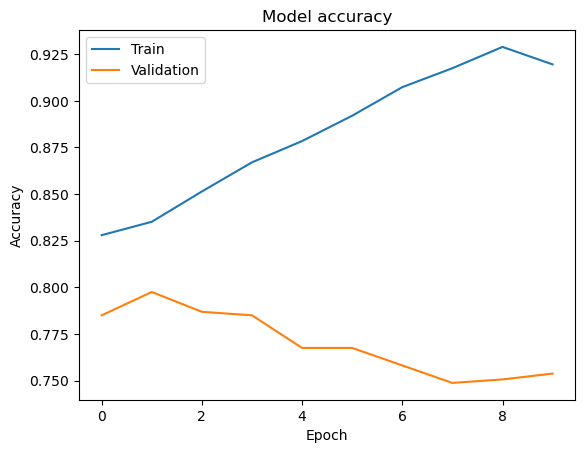

In [46]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

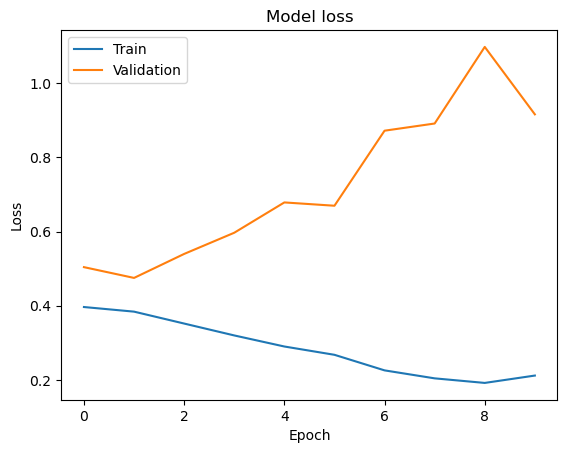

In [47]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Analysis
Based on the results, my model seems to be overfitting the data. I will fine tune the model my adding some regularization methods. For this second model, I will use droput layers in an attempt to improve test accuracy. 

I am choosing dropout due to its simple implementation as well as its randomization. 

Additionally I am also adding some L2 regularization due to it's robustness to outliers compared to L1.

In [51]:
# prep for test data to randomize again

test_image_files = os.listdir(test)
random_test_images = random.sample(test_image_files, 2000)
print("Number of selected test images: {}".format(len(random_test_images)))

random_test_image_ids = [filename.split('.')[0] for filename in random_test_images]

test_labels_dict = dict(zip(samples['id'], samples['label']))

# map images to labels
random_test_labels = [test_labels_dict[image_id] for image_id in random_test_image_ids]

test_data = pd.DataFrame({
    'filename': random_test_images,
    'label': random_test_labels
})

Number of selected test images: 2000


In [52]:
# preprocess again due to re-randomizing of test data

train_folder = "selected_images"
test_folder = "cancer-data/test"

img_width, img_height = 96, 96

def preprocess_test_data(data, folder):
    num_images = len(data)
    X = np.zeros((num_images, img_width, img_height, 3), dtype=np.float32)
    y = np.zeros(num_images, dtype=np.int32)
    
    label_dict = dict(zip(data['filename'], data['label']))
    
    for i, filename in enumerate(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array /= 255.0
        X[i] = img_array
        y[i] = label_dict[filename.split('.')[0]] 
        
    return X, y

X_train, y_train = preprocess_images(train_data, train_folder)

X_test, y_test = preprocess_images(test_data, test_folder)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.5862 - loss: 0.9847 - val_accuracy: 0.5900 - val_loss: 0.7111
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.6055 - loss: 0.6968 - val_accuracy: 0.5900 - val_loss: 0.6886
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.6025 - loss: 0.6827 - val_accuracy: 0.5900 - val_loss: 0.6827
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.6105 - loss: 0.6732 - val_accuracy: 0.5900 - val_loss: 0.6795
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.6021 - loss: 0.6746 - val_accuracy: 0.5900 - val_loss: 0.6783
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.6033 - loss: 0.6738 - val_accuracy: 0.5900 - val_loss: 0.6779
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.6066 - loss: 0.6716 - val_accuracy: 0.5900 - val_loss: 0.6780
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.5900 - loss: 0

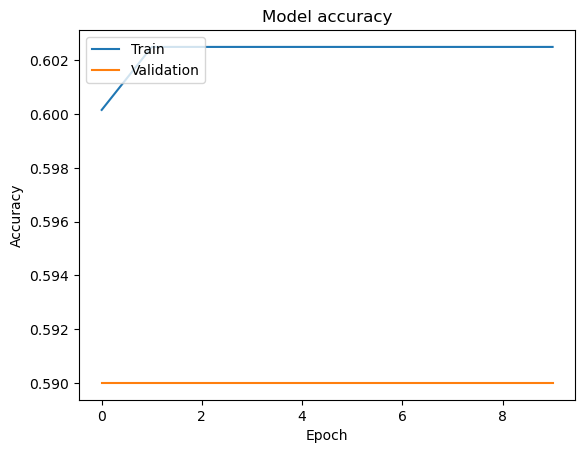

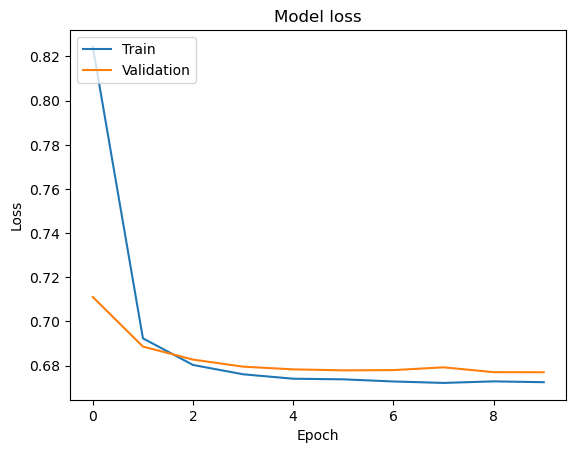

In [53]:
from tensorflow.keras import regularizers

def vgg_model_2(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model_2 = vgg_model_2(input_shape)
learning_rate_2 = 0.001

optimizer_2 = Adam(learning_rate=learning_rate_2)

model_2.compile(optimizer=optimizer_2, loss='binary_crossentropy', metrics=['accuracy'])

model_2.summary()

history_2 = model_2.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_acc_2 * 100))

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Conclusion

Regularization seemed to fix the issue of overfitting: however, 100% accuracy on test data is not realistic and is propably due to a memory error in the jupyter notebool. There needs to be further testing. 
Additionally, I would like to test the model with more data and epochs to see if the results are matched. 